In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some styling for our plots
sns.set_style('whitegrid')

In [ ]:
# Load the dataset
df = pd.read_csv('/content/online_retail_II.csv', encoding='latin1') # The encoding is important for this specific dataset

# See the first 5 rows to get a feel for the data
print(df.head())

# Get a summary of all columns, their data types, and non-null values
print(df.info())

# Get descriptive statistics for numerical columns (like mean, std, min, max)
print(df.describe())

# Check for missing values in each column
print(df.isnull().sum())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS      12.0   
1  489434    79323P                   PINK CHERRY LIGHTS      12.0   
2  489434    79323W                  WHITE CHERRY LIGHTS      12.0   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE       48.0   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX      24.0   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648645 entries, 0 to 648644
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice     

In [ ]:
# Identify return invoices (InvoiceNo starts with 'C')
df['is_cancelled'] = df['Invoice'].astype(str).str.startswith('C')

# Create a unique identifier for each product in each transaction
df['StockCode_Lower'] = df['StockCode'].str.lower()
df['Description_Lower'] = df['Description'].str.lower()

# Get a set of items that were returned
returned_items = set(df[df['is_cancelled'] == True]['StockCode_Lower'])

# Create the target variable
df['is_returned'] = np.where(df['StockCode_Lower'].isin(returned_items), 1, 0)

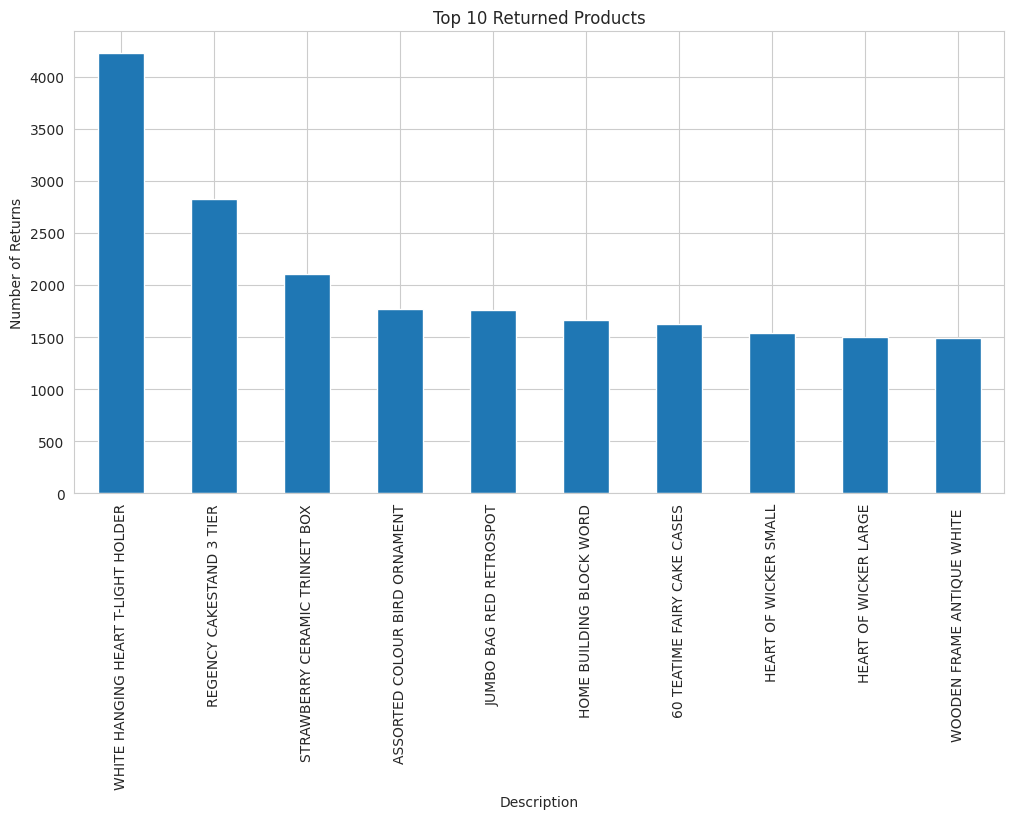

In [ ]:
# Filter for returned items
returned_df = df[df['is_returned'] == 1]

# Plot the top 10 most returned product descriptions
plt.figure(figsize=(12, 6))
returned_df['Description'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Returned Products')
plt.ylabel('Number of Returns')
plt.show()

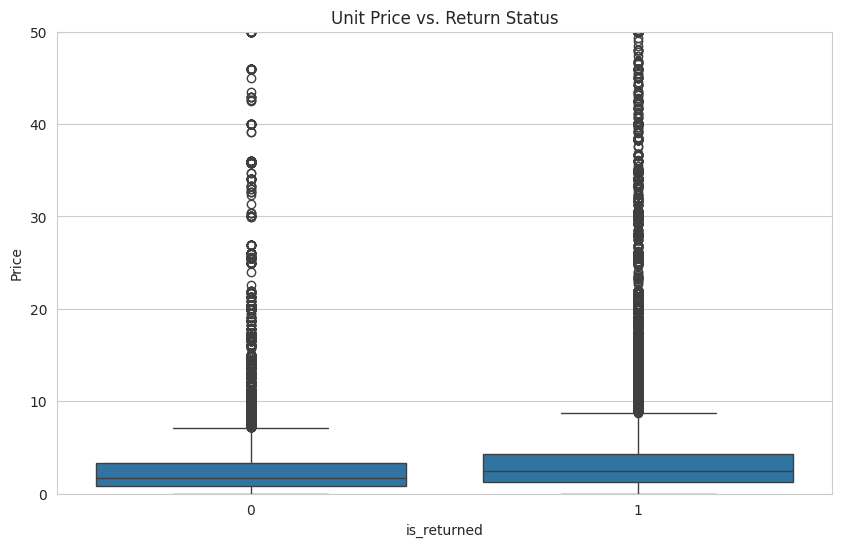

In [ ]:
# See the relationship between unit price and the return flag
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_returned', y='Price', data=df)
plt.title('Unit Price vs. Return Status')
plt.ylim(0, 50) # Limit y-axis to see the distribution better, excluding outliers
plt.show()

In [ ]:
# Drop rows with missing CustomerID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove the cancelled orders from our main dataframe
df = df[df['is_cancelled'] == False]

In [ ]:
# Feature 1: How many unique products has a customer bought?
customer_data = df.groupby('Customer ID')['StockCode'].nunique().reset_index().rename(columns={'StockCode': 'customer_unique_products'})
df = pd.merge(df, customer_data, on='Customer ID', how='left')

# Feature 2: What is the average price of items a customer buys?
customer_avg_price = df.groupby('Customer ID')['Price'].mean().reset_index().rename(columns={'Price': 'customer_avg_price'})
df = pd.merge(df, customer_avg_price, on='Customer ID', how='left')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select a subset of features to use
features = ['Quantity', 'Price', 'customer_unique_products', 'customer_avg_price', 'Country']
target = 'is_returned'

final_df = df[features + [target]].dropna()

# One-Hot Encode the 'Country' column
final_df = pd.get_dummies(final_df, columns=['Country'], drop_first=True)

# Separate features (X) from the target (y)
X = final_df.drop(target, axis=1)
y = final_df[target]

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12676
           1       0.87      1.00      0.93     85048

    accuracy                           0.87     97724
   macro avg       0.44      0.50      0.47     97724
weighted avg       0.76      0.87      0.81     97724



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/xgboost/t


--- XGBoost Report ---
              precision    recall  f1-score   support

           0       0.57      0.06      0.11     12676
           1       0.88      0.99      0.93     85048

    accuracy                           0.87     97724
   macro avg       0.73      0.53      0.52     97724
weighted avg       0.84      0.87      0.82     97724



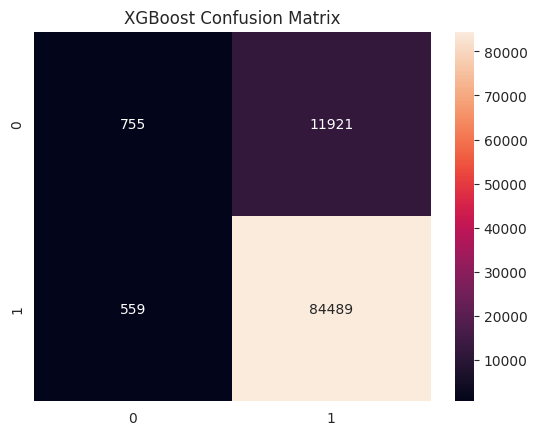

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Model 1: Logistic Regression (Baseline) ---
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_log))


# --- Model 2: XGBoost (Advanced) ---
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n--- XGBoost Report ---")
print(classification_report(y_test, y_pred_xgb))

# Visualize the confusion matrix for the better model
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [ ]:
import joblib

# Save the model
joblib.dump(xgb_model, 'return_prediction_model.joblib')

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

# Also save the column order, this is a CRITICAL step
joblib.dump(X.columns, 'model_columns.joblib')

['model_columns.joblib']